In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
widths = [1]*32
df = pd.read_fwf('digitdata/optdigits-orig_train.txt', widths=widths, header=None, skiprows=lambda x : (x+1) % 33 == 0)
# df
df_Y = pd.read_fwf('digitdata/optdigits-orig_train.txt', widths=[2], header=None, skiprows=lambda x : (x+1) % 33 != 0)

In [3]:
df_trainX = pd.DataFrame(df.values.reshape(2436, -1))
df_trainY = df_Y
df_trainY.columns = ['label']
# df_Y

In [4]:
df = pd.read_fwf('digitdata/optdigits-orig_test.txt', widths=widths, header=None, skiprows=lambda x : (x+1) % 33 == 0)
df_Y = pd.read_fwf('digitdata/optdigits-orig_test.txt', widths=[2], header=None, skiprows=lambda x : (x+1) % 33 != 0)


In [5]:
df_testX = pd.DataFrame(df.values.reshape(444, -1))
df_testY = df_Y
df_testY.columns = ['label']

In [6]:
class_count = np.array((df_trainY['label'].value_counts().sort_index()))
class_count

array([240, 250, 246, 251, 241, 237, 239, 250, 231, 251], dtype=int64)

In [7]:
class_log_prior = np.log(class_count) - np.log(len(df_trainY))
class_log_prior

array([-2.31747371, -2.27665171, -2.29278109, -2.27265969, -2.3133157 ,
       -2.33005249, -2.32164908, -2.27665171, -2.35569492, -2.27265969])

In [8]:
feature_count = np.array([[sum(df_trainX[df_trainY['label'] == i].iloc[:,j]) for i in range(10)] for j in range(1024)]).T
feature_count

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ..., 10,  6,  3],
       [ 0,  0,  0, ...,  9,  1,  1],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [9]:
def calc_feature_log_prob(feature_count, alpha=1):
    smoothed_fc = feature_count + alpha
    smoothed_cc = smoothed_fc.sum(axis=1)
    return (np.log(smoothed_fc) - np.log(smoothed_cc.reshape(-1, 1)))

In [10]:
feature_log_prob = [calc_feature_log_prob(feature_count, alpha=0.1), \
                    calc_feature_log_prob(feature_count, alpha=1), \
                    calc_feature_log_prob(feature_count, alpha=5), \
                    calc_feature_log_prob(feature_count, alpha=10)]
# feature_log_prob

In [11]:
joint_log_likelihood = [df_testX @ feature_log_prob[0].T + class_log_prior, \
                        df_testX @ feature_log_prob[1].T + class_log_prior, \
                        df_testX @ feature_log_prob[2].T + class_log_prior, \
                        df_testX @ feature_log_prob[3].T + class_log_prior]
# joint_log_likelihood

In [12]:
pred = [np.argmax(joint_log_likelihood[0], axis=1), \
        np.argmax(joint_log_likelihood[1], axis=1), \
        np.argmax(joint_log_likelihood[2], axis=1), \
        np.argmax(joint_log_likelihood[3], axis=1)]

In [13]:
smooth_k = [0.1, 1, 5, 10]
for i in range(4):
    y_pred = pd.Series(pred[i])
    df_confusion = pd.crosstab(df_testY['label'], y_pred)

    conf_percent = df_confusion.values / df_confusion.sum(axis=1).values.reshape(-1,1)
    df_conf_percent = round(pd.DataFrame(conf_percent).rename_axis('Actual').rename_axis('Prediction', axis=1), 4)*100
    print('Test set Confusion Matrix: Actual vs. Prediction (Smoothing value k = {})'.format(smooth_k[i]))
    display(df_conf_percent)
    display(pd.DataFrame(np.diag(df_conf_percent), columns=['Accuracy']))
    print('Average Accuracy: {}'.format(np.mean(np.diag(df_conf_percent))))
    print('\n')
# df_conf_percent

Test set Confusion Matrix: Actual vs. Prediction (Smoothing value k = 0.1)


Prediction,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,97.22,0.00,0.00,0.00,2.78,0.00,0.00,0.00,0.00,0.00
1,0.00,88.89,2.22,0.00,0.00,0.00,0.00,2.22,4.44,2.22
2,0.00,0.00,85.37,0.00,0.00,0.00,0.00,0.00,12.20,2.44
3,0.00,0.00,0.00,87.88,0.00,0.00,0.00,3.03,3.03,6.06
4,0.00,0.00,0.00,0.00,89.83,0.00,0.00,5.08,5.08,0.00
5,0.00,1.72,0.00,0.00,0.00,89.66,0.00,0.00,0.00,8.62
6,0.00,0.00,0.00,0.00,0.00,0.00,97.67,0.00,2.33,0.00
7,0.00,0.00,0.00,0.00,0.00,2.13,0.00,97.87,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00


,Accuracy
0,97.22
1,88.89
2,85.37
3,87.88
4,89.83
5,89.66
6,97.67
7,97.87
8,100.00
9,88.10


Average Accuracy: 92.24900000000001


Test set Confusion Matrix: Actual vs. Prediction (Smoothing value k = 1)


Prediction,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,97.22,0.00,0.00,0.00,2.78,0.00,0.00,0.00,0.00,0.00
1,0.00,88.89,2.22,0.00,0.00,0.00,0.00,2.22,4.44,2.22
2,0.00,0.00,85.37,0.00,0.00,0.00,0.00,0.00,12.20,2.44
3,0.00,0.00,0.00,87.88,0.00,0.00,0.00,3.03,3.03,6.06
4,0.00,0.00,0.00,0.00,89.83,0.00,0.00,5.08,5.08,0.00
5,0.00,1.72,0.00,0.00,0.00,89.66,0.00,0.00,0.00,8.62
6,0.00,0.00,0.00,0.00,0.00,0.00,97.67,0.00,2.33,0.00
7,0.00,0.00,0.00,0.00,0.00,2.13,0.00,97.87,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00


,Accuracy
0,97.22
1,88.89
2,85.37
3,87.88
4,89.83
5,89.66
6,97.67
7,97.87
8,100.00
9,90.48


Average Accuracy: 92.48700000000001


Test set Confusion Matrix: Actual vs. Prediction (Smoothing value k = 5)


Prediction,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,97.22,0.00,0.00,0.00,2.78,0.00,0.00,0.00,0.00,0.00
1,0.00,91.11,0.00,0.00,0.00,0.00,0.00,2.22,4.44,2.22
2,0.00,0.00,85.37,0.00,0.00,0.00,0.00,0.00,12.20,2.44
3,0.00,0.00,0.00,90.91,0.00,0.00,0.00,3.03,0.00,6.06
4,0.00,0.00,0.00,0.00,89.83,0.00,0.00,5.08,5.08,0.00
5,0.00,1.72,0.00,0.00,0.00,89.66,0.00,0.00,0.00,8.62
6,0.00,0.00,0.00,0.00,0.00,0.00,97.67,0.00,2.33,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.87,2.13,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00


,Accuracy
0,97.22
1,91.11
2,85.37
3,90.91
4,89.83
5,89.66
6,97.67
7,97.87
8,100.00
9,90.48


Average Accuracy: 93.01200000000001


Test set Confusion Matrix: Actual vs. Prediction (Smoothing value k = 10)


Prediction,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,97.22,0.00,0.00,0.00,2.78,0.00,0.00,0.00,0.00,0.00
1,0.00,91.11,0.00,0.00,0.00,0.00,0.00,2.22,4.44,2.22
2,0.00,0.00,85.37,0.00,0.00,0.00,0.00,0.00,12.20,2.44
3,0.00,0.00,0.00,90.91,0.00,0.00,0.00,3.03,0.00,6.06
4,0.00,0.00,0.00,0.00,89.83,0.00,0.00,5.08,5.08,0.00
5,0.00,1.72,0.00,0.00,0.00,89.66,0.00,0.00,0.00,8.62
6,0.00,0.00,0.00,0.00,0.00,0.00,97.67,0.00,2.33,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,97.87,2.13,0.00
8,0.00,2.50,0.00,0.00,0.00,0.00,0.00,0.00,97.50,0.00


,Accuracy
0,97.22
1,91.11
2,85.37
3,90.91
4,89.83
5,89.66
6,97.67
7,97.87
8,97.50
9,88.10


Average Accuracy: 92.52400000000002




### Choose the smoothing parameter with the best average accuracy (k=5)

In [14]:
LL_pred = pd.concat([pd.DataFrame(joint_log_likelihood[2]), df_testY], axis=1)
# LL_pred

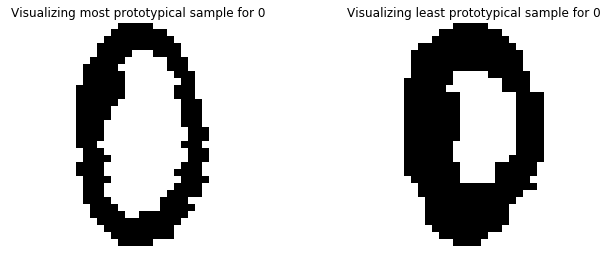

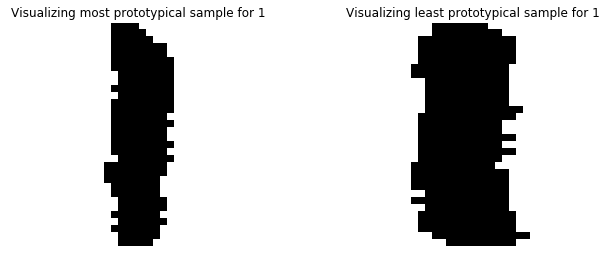

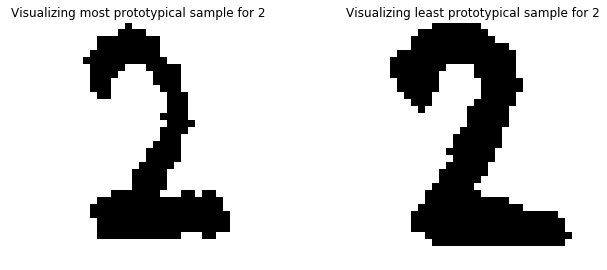

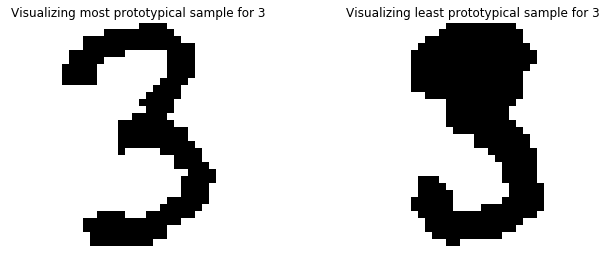

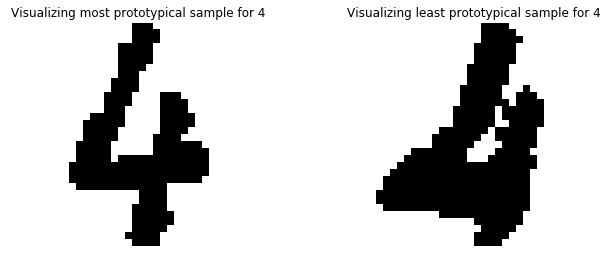

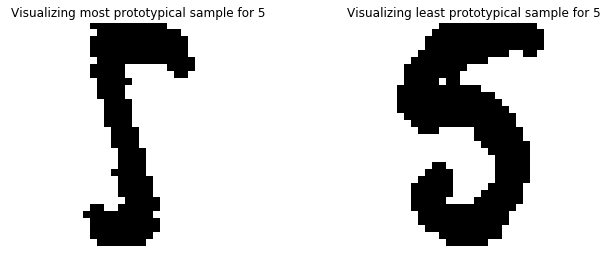

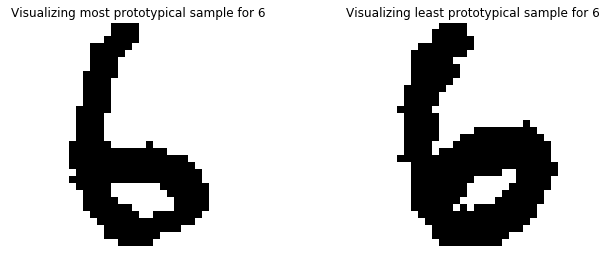

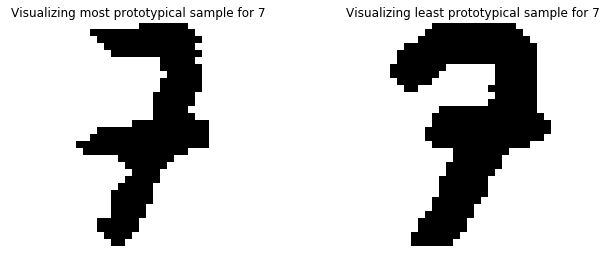

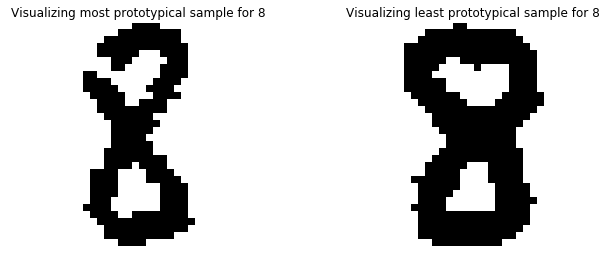

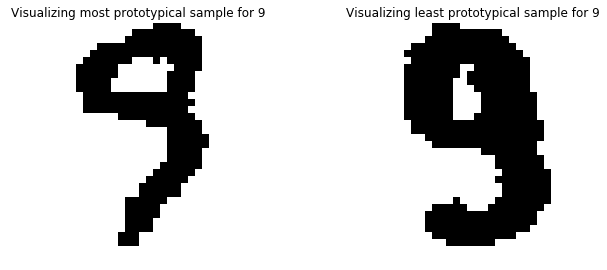

In [15]:
for index in range(10):
    i_most = LL_pred[LL_pred['label']==index].iloc[:,index].idxmax()
    i_least = LL_pred[LL_pred['label']==index].iloc[:,index].idxmin()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.imshow(df_testX.iloc[i_most,:].values.reshape((32,32)), cmap='Greys')
    ax2.imshow(df_testX.iloc[i_least,:].values.reshape((32,32)), cmap='Greys')
    ax1.set_title('Visualizing most prototypical sample for {}'.format(index))
    ax2.set_title('Visualizing least prototypical sample for {}'.format(index))
    ax1.axis('off')
    ax2.axis('off')
    plt.subplots_adjust(wspace=0.5)
    plt.show()


In [16]:
def plot_log_odds_ratio(c1, c2):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    ax1 = sns.heatmap(feature_log_prob[2][c1].reshape((32,32)), ax=ax1, cmap='jet', xticklabels=False, yticklabels=False)
    ax2 = sns.heatmap(feature_log_prob[2][c2].reshape((32,32)), ax=ax2, cmap='jet', xticklabels=False, yticklabels=False)
    ax3 = sns.heatmap((feature_log_prob[2][c1] - feature_log_prob[2][c2]).reshape((32,32)), ax=ax3, cmap='jet', xticklabels=False, yticklabels=False)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

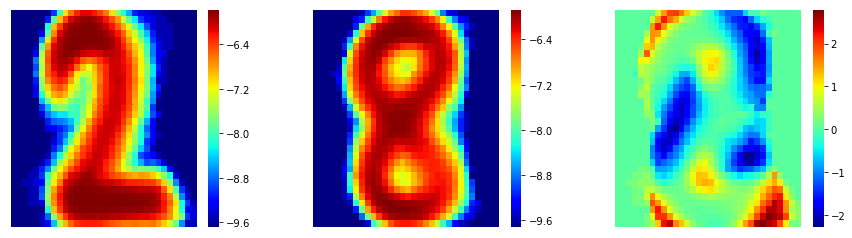

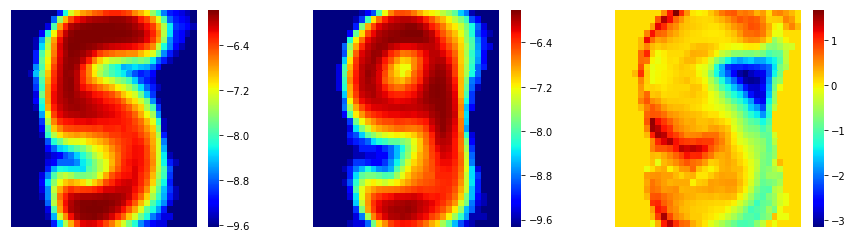

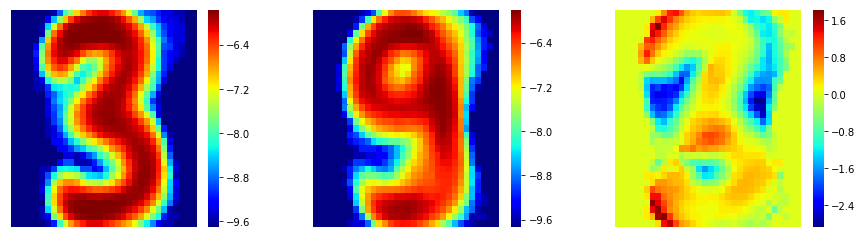

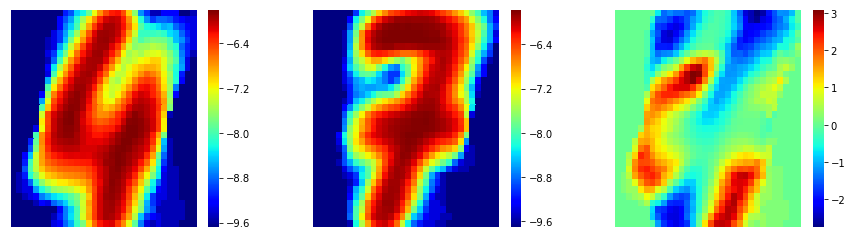

In [17]:
for i, cls in enumerate(zip([2,5,3,4], [8,9,9,7])):
    plot_log_odds_ratio(cls[0], cls[1])